In [1]:
import os

os.chdir('../..')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
results = pd.read_csv("output/results_ptbxl.csv", index_col="Method")
results = results['exp4_AUC'].to_frame()
results = results[results['exp4_AUC']!='---']

In [4]:
results

,exp4_AUC
Method,
models\AttNet+dp02+lead1,0.830(14)
models\VGGNet+lead1,0.805(19)
models\ResNet+Baseline+lead1,0.807(21)
models\AlexNet+lead1,0.838(16)
models\Wavelet+NN,0.818(25)
models\NewWavelet+NN+lead1,0.766(22)
models\LeNet+lead1,0.819(14)
models\Simple+Baseline+lead1,0.681(27)
models\InceptionSE+lead1,0.758(19)


In [5]:
results['AUC'] = results['exp4_AUC'].str.extract(r'(\d+\.\d+)', expand=False).astype(float)
results['CI'] = results['exp4_AUC'].str.extract(r'\((\d+)\)', expand=False).astype(float)
results['CI'] = results['CI']/1000

In [6]:
results.index = pd.Categorical(results.index)
results.sort_index(inplace=True)
results.index = results.index.str.replace(r'models\\', '')
results = results.sort_values("AUC")

C:\Users\agarw\AppData\Local\Temp\ipykernel_30968\3330354323.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  results.index = results.index.str.replace(r'models\\', '')


In [7]:
results = results[results['AUC']>0.8]

<ErrorbarContainer object of 3 artists>

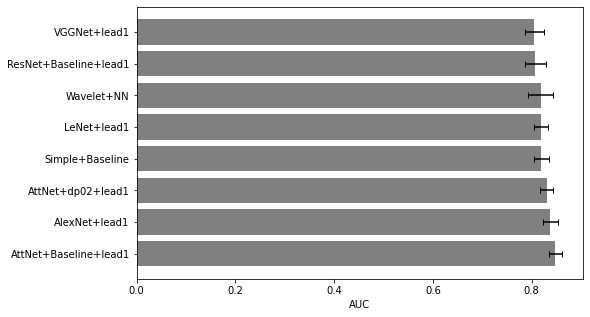

In [8]:
plt.figure(figsize=(8,5))
ax = sns.barplot(y=results.index, x=results['AUC'], orient='h', color='grey')
ax.errorbar(y=results.index, xerr=results['CI'], x=results['AUC'], capsize=3, ecolor='black', linestyle='none')

In [9]:
results.index

Index(['VGGNet+lead1', 'ResNet+Baseline+lead1', 'Wavelet+NN', 'LeNet+lead1',
       'Simple+Baseline', 'AttNet+dp02+lead1', 'AlexNet+lead1',
       'AttNet+Baseline+lead1'],
      dtype='object')

In [10]:
import glob

def generate_summary_table(selection=None, exps=None, folder='output/'):
    if exps is None:
        exps = ['exp0', 'exp1', 'exp1.1', 'exp1.1.1', 'exp2', 'exp3','exp4']
    metric1 = 'macro_auc'
    
    # getmodels
    models = {}
    for i,exp in enumerate(exps):
        if selection is None:
            exp_models = [m.split('/')[-1] for m in glob.glob(f'{folder}{exp}/models/*')]
            if len(exp_models)==0:
                exp_models = [m.split('/')[-1] for m in glob.glob(f'{folder}/{exp}/models/*')]
            print(exp_models)
        else:
            exp_models = selection
        if i==0:
            models = set(exp_models)
        else:
            models = models.union(set(exp_models))
    
    results_dic = {'Method': []}
    for exp in exps:
        results_dic[f'{exp}_AUC'] = []
    
    for model in models:
        results_dic['Method'].append(model)
        
        for e in exps:
            try:
                if 'models' in model:
                    if 'demo' in folder:
                        me_res =pd.read_csv(folder+str(e)+'/'+str(model)+'/results/demo_te_results.csv', index_col=0)
                    else:
                        me_res = pd.read_csv(folder+str(e)+'/'+str(model)+'/results/te_results.csv', index_col=0)
                else:
                    me_res = pd.read_csv(folder+str(e)+'/models/'+str(model)+'/results/te_results.csv', index_col=0)
                
                mean1 = me_res.loc['point'][metric1]
                unc1 = max(me_res.loc['upper'][metric1]-me_res.loc['point'][metric1], me_res.loc['point'][metric1]-me_res.loc['lower'][metric1])
                print(mean1, unc1)
                results_dic[e+'_AUC'].append("%.3f(%.2d)" %(np.round(mean1,3), int(unc1*1000)))
            except FileNotFoundError:
                results_dic[e+'_AUC'].append("---")
    
    df = pd.DataFrame(results_dic)
    df_index = df[df.Method.isin(['naive', 'ensemble'])]
    df_rest = df[~df.Method.isin(['naive', 'ensemble'])]
    df = pd.concat([df_rest, df_index])
    # df.to_csv(folder+'results_ptbxl.csv')
    
    print(df)
    return df

In [11]:
import pickle

idxs = results.index
with open(r"C:\Mohit\Imperial\fyp-hearts\output\exp4\data\mlb.pkl", 'rb') as f:
    mlb = pickle.load(f).classes_

mlb

array(['2AVB', '3AVB', 'ABQRS', 'AFIB', 'AFLT', 'ALMI', 'AMI', 'ASMI',
       'CLBBB', 'CRBBB', 'EL', 'ILMI', 'IMI', 'INJAL', 'INJAS', 'INJIL',
       'INJIN', 'INJLA', 'IPLMI', 'IPMI', 'ISCAL', 'ISCAN', 'ISCAS',
       'ISCIL', 'ISCIN', 'ISCLA', 'ISC_', 'LMI', 'LNGQT', 'NDT', 'NORM',
       'NST_', 'PAC', 'PMI', 'PSVT', 'PVC', 'SBRAD', 'SR', 'STD_', 'STE_',
       'SVTAC', 'TAB_', 'WPW'], dtype=object)

<BarContainer object of 8 artists>

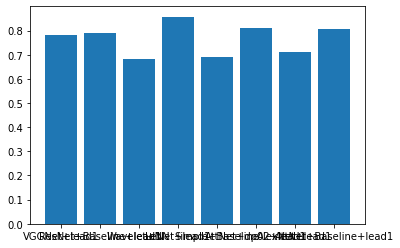

In [12]:
from sklearn.metrics import roc_auc_score
y_test = np.load(f"output/exp4/data/y_test.npy", allow_pickle=True)
# for idx in idxs:
    
wpw = y_test[:,-1]
aucs = []

for idx in idxs:
    y_test_pred = np.load(f"output/exp4/models/{idx}/y_test_pred.npy", allow_pickle=True)[:,-1]
    aucs += [roc_auc_score(wpw, y_test_pred)]

plt.bar(idxs, aucs)

<BarContainer object of 8 artists>

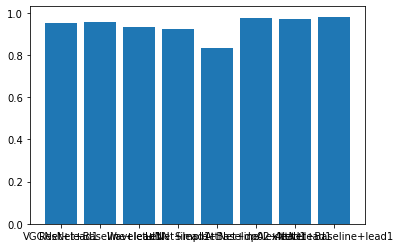

In [13]:
afib = y_test[:,3]
aucs = []

for idx in idxs:
    y_test_pred = np.load(f"output/exp4/models/{idx}/y_test_pred.npy", allow_pickle=True)[:,3]
    aucs += [roc_auc_score(afib, y_test_pred)]

plt.bar(idxs, aucs)

[0.8967772069126576,
 0.9037832788416628,
 0.9556949356108627,
 0.9615666911323147,
 0.8331887635951158,
 0.8620137452458797,
 0.8913057983585775,
 0.886034563288183]

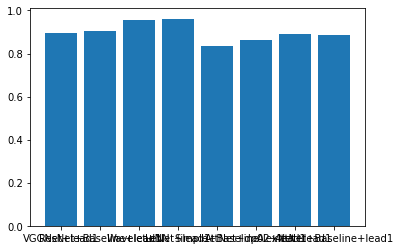

In [14]:
aflt = y_test[:,4]
aucs = []

for idx in idxs:
    y_test_pred = np.load(f"output/exp4/models/{idx}/y_test_pred.npy", allow_pickle=True)[:,4]
    aucs += [roc_auc_score(aflt, y_test_pred)]

plt.bar(idxs, aucs)
aucs

In [15]:
df = pd.DataFrame(columns=idxs, index=mlb)

for i in range(43):
    aflt = y_test[:,i]
    aucs =[]
    for idx in idxs:
        y_test_pred = np.load(f"output/exp4/models/{idx}/y_test_pred.npy", allow_pickle=True)[:,i]
        aucs += [roc_auc_score(aflt, y_test_pred)]
    df.loc[mlb[i]] = aucs

df['mean'] = df.mean(axis=1)
df

,VGGNet+lead1,ResNet+Baseline+lead1,Wavelet+NN,LeNet+lead1,Simple+Baseline,AttNet+dp02+lead1,AlexNet+lead1,AttNet+Baseline+lead1,mean
2AVB,0.895668,0.853749,0.448999,0.514206,0.52585,0.97252,0.979506,0.988822,0.772415
3AVB,0.923579,0.926608,0.875815,0.930103,0.926608,0.990214,0.944082,0.996272,0.939160
ABQRS,0.618194,0.658474,0.755339,0.653836,0.751396,0.639547,0.652746,0.644532,0.671758
AFIB,0.950071,0.957346,0.932572,0.925311,0.833091,0.974765,0.969808,0.981763,0.940591
AFLT,0.896777,0.903783,0.955695,0.961567,0.833189,0.862014,0.891306,0.886035,0.898796
ALMI,0.816858,0.900519,0.859291,0.947003,0.886584,0.909023,0.837131,0.872806,0.878652
AMI,0.620147,0.622311,0.78326,0.702982,0.650679,0.702346,0.682963,0.688459,0.681643
ASMI,0.832259,0.821462,0.919257,0.821256,0.921463,0.835881,0.840172,0.844039,0.854474
CLBBB,0.996126,0.994716,0.997144,0.996056,0.990113,0.993297,0.990891,0.996807,0.994394
CRBBB,0.981499,0.990962,0.980252,0.992474,0.991572,0.990661,0.988088,0.985903,0.987676


In [16]:
counts = []
for i in range(43):
    counts += [np.count_nonzero(y_test[:,i]==1)]

df['Counts'] = counts
df

,VGGNet+lead1,ResNet+Baseline+lead1,Wavelet+NN,LeNet+lead1,Simple+Baseline,AttNet+dp02+lead1,AlexNet+lead1,AttNet+Baseline+lead1,mean,Counts
2AVB,0.895668,0.853749,0.448999,0.514206,0.52585,0.97252,0.979506,0.988822,0.772415,1
3AVB,0.923579,0.926608,0.875815,0.930103,0.926608,0.990214,0.944082,0.996272,0.939160,2
ABQRS,0.618194,0.658474,0.755339,0.653836,0.751396,0.639547,0.652746,0.644532,0.671758,322
AFIB,0.950071,0.957346,0.932572,0.925311,0.833091,0.974765,0.969808,0.981763,0.940591,152
AFLT,0.896777,0.903783,0.955695,0.961567,0.833189,0.862014,0.891306,0.886035,0.898796,7
ALMI,0.816858,0.900519,0.859291,0.947003,0.886584,0.909023,0.837131,0.872806,0.878652,27
AMI,0.620147,0.622311,0.78326,0.702982,0.650679,0.702346,0.682963,0.688459,0.681643,35
ASMI,0.832259,0.821462,0.919257,0.821256,0.921463,0.835881,0.840172,0.844039,0.854474,234
CLBBB,0.996126,0.994716,0.997144,0.996056,0.990113,0.993297,0.990891,0.996807,0.994394,54
CRBBB,0.981499,0.990962,0.980252,0.992474,0.991572,0.990661,0.988088,0.985903,0.987676,54


In [23]:
from sklearn.metrics import f1_score
y_test_pred = np.load("output/exp4/models/NewWavelet+NN+lead1/y_test_pred.npy", allow_pickle=True)
f1_score(y_test, (y_test_pred>0.5).astype(int), average="macro")
roc_auc_score(y_test, y_test_pred)

0.11065358210675698

In [20]:
import tensorflow as tf

tf.keras.metrics.F1Score()(y_test, y_test_pred)

AttributeError: module 'keras.api._v2.keras.metrics' has no attribute 'F1Score'

In [19]:
from sklearn.metrics import f1_score

idx = idxs[-1]

y_test_pred = np.load(f"output/exp4/models/{idx}/y_test_pred.npy", allow_pickle=True)

# f1_score(y_test, (y_test_pred > 0.5).astype(int), average="macro")

In [29]:
f1 = pd.DataFrame(columns=idxs, index=mlb)

for i in range(43):
    aflt = y_test[:,i]
    aucs =[]
    for idx in idxs:
        y_test_pred = np.load(f"output/exp4/models/{idx}/y_test_pred.npy", allow_pickle=True)[:,i]
        aucs += [f1_score(aflt, (y_test_pred>0.5).astype(int))]
    f1.loc[mlb[i]] = aucs

f1['Counts'] = counts
f1['mean'] = f1.mean(axis=1)
f1

,VGGNet+lead1,ResNet+Baseline+lead1,Wavelet+NN,LeNet+lead1,Simple+Baseline,AttNet+dp02+lead1,AlexNet+lead1,AttNet+Baseline+lead1,mean,Counts
2AVB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1
3AVB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2
ABQRS,0.0,0.0,0.257611,0.142494,0.241135,0.052786,0.030395,0.070845,0.099408,322
AFIB,0.648649,0.297436,0.47619,0.422414,0.26455,0.816054,0.745098,0.83871,0.563638,152
AFLT,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.375,0.096875,7
ALMI,0.0,0.0,0.071429,0.129032,0.0,0.0,0.137931,0.25,0.073549,27
AMI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,35
ASMI,0.0,0.0,0.533693,0.148699,0.428571,0.143396,0.049587,0.110236,0.176773,234
CLBBB,0.857143,0.846154,0.86,0.841121,0.707071,0.865385,0.658824,0.87037,0.813258,54
CRBBB,0.549451,0.225806,0.666667,0.747664,0.693878,0.727273,0.732143,0.564103,0.613373,54


In [32]:
y_test_pred = np.load(f"output/exp4/models/{idx}/y_test_pred.npy", allow_pickle=True)
f1_score(y_test, (y_test_pred > 0.5).astype(int), average="samples")

0.6763678283231356

In [ ]:
## Check the probability in the training set

In [46]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test[:,8],(y_test_pred[:,8]>0.5).astype(int))

array([[2087,    7],
       [   7,   47]], dtype=int64)

In [34]:
import utils
utils.generate_summary_table()

['models\\AlexNet+lead1', 'models\\AttNet+Baseline+lead1', 'models\\AttNet+dp02+lead1', 'models\\ensemble', 'models\\LeNet+lead1', 'models\\naive', 'models\\ResNet+Baseline', 'models\\ResNet+Baseline+lead1', 'models\\Simple+Baseline', 'models\\Simple+Baseline+1024', 'models\\Simple+Baseline+1024+selu', 'models\\Simple+Baseline+12', 'models\\Simple+Baseline+12+selu', 'models\\Simple+Baseline+128', 'models\\Simple+Baseline+128+selu', 'models\\Simple+Baseline+16', 'models\\Simple+Baseline+16+selu', 'models\\Simple+Baseline+2048', 'models\\Simple+Baseline+2048+selu', 'models\\Simple+Baseline+256', 'models\\Simple+Baseline+256+selu', 'models\\Simple+Baseline+32', 'models\\Simple+Baseline+32+selu', 'models\\Simple+Baseline+512', 'models\\Simple+Baseline+512+selu', 'models\\Simple+Baseline+64', 'models\\Simple+Baseline+64+selu', 'models\\Simple+Baseline+8', 'models\\Simple+Baseline+8+selu', 'models\\Simple+Baseline+lead1', 'models\\Simple+Baseline+lead1+1024', 'models\\Simple+Baseline+lead1+1

,Method,exp0_AUC,exp1_AUC,exp1.1_AUC,exp1.1.1_AUC,exp2_AUC,exp3_AUC,exp4_AUC
0,models\Simple+Baseline+32+selu,0.792(14),0.845(12),0.815(31),0.856(07),---,---,---
1,models\Simple+Baseline+8+selu,0.810(11),0.843(12),0.815(16),0.864(08),---,---,---
2,models\Simple+Baseline+lead1+128+selu,0.655(21),0.681(25),0.702(21),0.703(13),0.552(27),0.636(29),---
3,models\Simple+Baseline,0.819(12),0.850(13),0.849(25),0.865(08),0.763(20),0.759(34),0.819(15)
4,models\Simple+Baseline+2048+selu,0.618(13),0.628(19),0.711(29),0.844(09),---,---,---
5,models\Simple+Baseline+lead1,0.672(16),0.696(26),0.693(26),0.704(14),0.583(35),0.650(32),0.681(27)
6,models\Simple+Baseline+lead1+8,0.666(17),0.691(26),0.687(25),0.704(11),---,---,---
7,models\Simple+Baseline+lead1+16+selu,0.655(19),0.687(23),0.697(21),0.701(12),0.589(37),0.647(26),---
8,models\Simple+Baseline+lead1+32,0.661(19),0.692(27),0.687(29),0.703(13),0.570(30),0.632(32),---
9,models\Simple+Baseline+512,0.707(18),0.778(20),0.789(28),0.851(09),---,---,---


In [44]:
list(mlb).index("CRBBB")

9

In [49]:
y_test = np.load(f"output/exp4/data/y_test.npy", allow_pickle=True)
y_train = np.load(f"output/exp4/data/y_train.npy", allow_pickle=True)
y_val = np.load(f"output/exp4/data/y_val.npy", allow_pickle=True)

y_train.shape, y_val.shape, y_test.shape

((17080, 43), (2135, 43), (2148, 43))

In [7]:
import numpy as np

exps =['exp0', 'exp1', 'exp1.1', 'exp1.1.1', 'exp2', 'exp3']
for exp in exps:
    file = f"C:\Mohit\Imperial\\fyp-hearts\output\{exp}\data\mlb.pkl"
    file = np.load(file, allow_pickle=True).classes_
    print(exp, len(file))

exp0 71
exp1 44
exp1.1 23
exp1.1.1 5
exp2 19
exp3 12


c:\Users\agarw\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator MultiLabelBinarizer from version 1.3.0 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
